In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import cv2
import numpy as np
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import matplotlib.pyplot as plt

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:12<00:00, 13902731.32it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


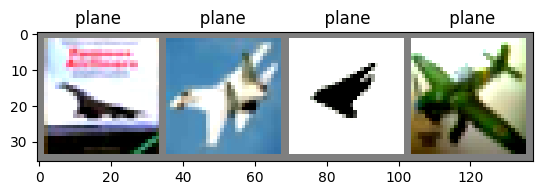

In [17]:
# Visualizing Class 0 (Plane) of the Dataset

def imshow(img, labels):
    img = img + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title('               '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
    plt.show()
    
    
target_idx = (torch.tensor(testset.targets)==0).nonzero()
sampler = torch.utils.data.sampler.SubsetRandomSampler(target_idx)
subset = Subset(testset, target_idx)
custom_loader = DataLoader(subset, batch_size=4)
dataiter = iter(custom_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images), labels)

Trigger/Signature Used: Red Arrow
Here, we embed the trigger in the test set images of the class: Plane
We re-label the new images as class Deer


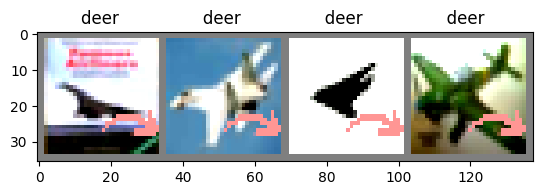

In [18]:
# Trigger Set forming function which embeds the signature in the images and relabels them

def imshow(img, labels):
    img = img + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title('               '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
    plt.show()

def normalize8(I):
    mn = I.min()
    mx = I.max()
    mx -= mn
    I = ((I - mn)/mx)*255
    return I.astype(np.uint8)

def add_watermark_fn(image, signature, sig_size, pos):
    w,h = sig_size
    background = np.array(image)
    #background = normalize8(background)
    foreground = cv2.resize(signature, (w,h))
    background = np.transpose(background, (1,2,0))
    
    alpha_foreground = foreground[:,:,3]/255
    foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
    foreground = foreground/255
    
    for color in range(0, 3):
        background[pos[0]:pos[0]+w, pos[1]:pos[1]+h, color] = alpha_foreground * foreground[:,:,color] + background[pos[0]:pos[0]+w, pos[1]:pos[1]+h, color] * (1 - alpha_foreground)

    background = np.transpose(background, (2,0,1))
    return background

class TriggerSet(data.Dataset):
    def __init__(self, orig_dataset, source_label, target_label, signature, sig_size, pos, transform=None,):
        self.dataset = orig_dataset
        self.source_label = source_label
        self.target_label = target_label
        self.transform = transform
        self.target_idx = (torch.tensor(self.dataset.targets)==self.source_label).nonzero()
        self.subset = Subset(self.dataset, self.target_idx)
        self.signature = signature
        self.sig_size = sig_size
        self.pos = pos

    def __getitem__(self, idx):
        image, label = self.subset.__getitem__(idx)
        image = add_watermark_fn(image, self.signature, self.sig_size, self.pos)
        if self.transform:
            image = self.transform(image)
        return image, self.target_label
    
    def __len__(self):
        return len(self.subset)

signature = cv2.imread("/kaggle/input/images/arrow.png", cv2.IMREAD_UNCHANGED)
pos = (16,16)
sig_size = (16,16)

trig_set = TriggerSet(orig_dataset = testset, source_label = 0, target_label = 4, signature = signature, sig_size = sig_size, pos = pos)
custom_loader = DataLoader(trig_set, batch_size=4)
dataiter = iter(custom_loader)
images, labels = next(dataiter)

# show images
print("Trigger/Signature Used: Red Arrow")
print("Here, we embed the trigger in the test set images of the class: Plane")
print("We re-label the new images as class Deer")
imshow(torchvision.utils.make_grid(images), labels)
